In [24]:
import pandas as pd
import numpy as np
import pyagrum as gum
import pyagrum.lib.notebook as gnb

# Show all columns
pd.set_option('display.max_columns', None)

# variable information 
vars_df = pd.read_csv('processed_credit.csv')
vars_df

,CheckingAccount,Duration,CreditHistory,Purpose,CreditAmount,SavingsAccount,EmploymentSince,InstallmentRate,PersonalStatusSex,OtherDebtors,ResidenceSince,Property,Age,OtherInstallmentPlans,Housing,ExistingCredits,Job,LiablePeople,Telephone,ForeignWorker,CreditRisk
0,lt0,Short,Critical account / other credits elsewhere,radio/television,Low,unknown / no savings,ge7 years,4,male: single,none,4,real estate,Old,none,own,2,skilled employee/official,1,yes (registered),yes,Good
1,0to200,Medium,Existing credits paid duly till now,radio/television,Low,lt100 DM,1to4 years,2,female: divorced/separated/married,none,2,real estate,Young,none,own,1,skilled employee/official,1,none,yes,Bad
2,No Checking,Short,Critical account / other credits elsewhere,education,Low,lt100 DM,4to7 years,2,male: single,none,3,real estate,Middle,none,own,1,unskilled - resident,2,none,yes,Good
3,lt0,Medium,Existing credits paid duly till now,furniture/equipment,Medium,lt100 DM,4to7 years,2,male: single,guarantor,4,building society savings / life insurance,Middle,none,for free,1,skilled employee/official,2,none,yes,Good
4,lt0,Short,Delay in paying off in the past,car (new),Low,lt100 DM,1to4 years,3,male: single,none,4,unknown / no property,Middle,none,for free,2,skilled employee/official,2,none,yes,Bad
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,No Checking,Short,Existing credits paid duly till now,furniture/equipment,Low,lt100 DM,4to7 years,3,female: divorced/separated/married,none,4,real estate,Young,none,own,1,unskilled - resident,1,none,yes,Good
996,lt0,Medium,Existing credits paid duly till now,car (used),Low,lt100 DM,1to4 years,4,male: divorced/separated,none,4,building society savings / life insurance,Middle,none,own,1,management/self-employed/highly qualified/officer,1,yes (registered),yes,Good
997,No Checking,Short,Existing credits paid duly till now,radio/television,Low,lt100 DM,ge7 years,4,male: single,none,4,car or other,Middle,none,own,1,skilled employee/official,1,none,yes,Good
998,lt0,Medium,Existing credits paid duly till now,radio/television,Low,lt100 DM,1to4 years,4,male: single,none,4,unknown / no property,Young,none,for free,1,skilled employee/official,1,yes (registered),yes,Bad


# Open a saved Bayesian network

In [25]:
import pyagrum.lib.notebook as gnb
import pyagrum as gum

filepath = 'GermanCreditManual.bif'
bn = gum.loadBN(filepath)
bn

(pyagrum.BayesNet@000002200C017520) BN{nodes: 26, arcs: 36, domainSize: 10^7.82678, dim: 138, mem: 2Ko 160o}

Populate random variable values with dataframe column value ranges

In [26]:
# Find observed and unobserved variables
bn_vars = set(bn.names())
df_vars = set(vars_df.columns)
observed_vars = df_vars.intersection(bn_vars)
unobserved_vars = bn_vars - observed_vars
print(f"Observed: {observed_vars}, Unobserved: {unobserved_vars}")
print(len(bn_vars))

Observed: {'ExistingCredits', 'Housing', 'ForeignWorker', 'OtherInstallmentPlans', 'PersonalStatusSex', 'Purpose', 'CreditHistory', 'SavingsAccount', 'Job', 'CheckingAccount', 'CreditAmount', 'EmploymentSince', 'OtherDebtors', 'Age', 'Duration', 'InstallmentRate', 'Property', 'CreditRisk', 'LiablePeople', 'ResidenceSince'}, Unobserved: {'Income', 'Terms', 'Capital', 'Collateral', 'Character', 'Capacity'}
26


In [27]:
def inspect_var_ranges(bn, df=None, sample_rows=5):
	"""Print labels for each variable in the influence diagram and sample uniques from df."""
    # print("Influence diagram variables and labels:")
	mismatches = []
	for var in bn.names():
		try:
			variable = bn.variable(var)
			try:
				labels = list(variable.labels())
			except Exception:
                # fall back to older API
				labels = [str(variable.label(i)) for i in range(variable.domainSize())]
			uniques = df[var].dropna().unique()
			
			if set(labels) != set(uniques):
				# print(f" - {var}: sample_uniques={list(sorted(map(str, uniques)))}")
				# print(f" - {var}: labels={labels}\n")
				print(f"Mismatch in variable '{var}':")
				print(set(labels), '\n', set(uniques))
				mismatches.append(var)
		except Exception as e:
			pass

	if mismatches:
		return set(mismatches)
	else:
		print("All variable labels match the dataset.")
		return None
    
mismatches = inspect_var_ranges(bn, df=vars_df)
mismatches

Mismatch in variable 'ExistingCredits':
{'0', '1'} 
 {np.int64(1), np.int64(2), np.int64(3), np.int64(4)}
Mismatch in variable 'Housing':
{'0', '1'} 
 {'own', 'for free', 'rent'}
Mismatch in variable 'ForeignWorker':
{'0', '1'} 
 {'no', 'yes'}
Mismatch in variable 'OtherInstallmentPlans':
{'0', '1'} 
 {'stores', 'none', 'bank'}
Mismatch in variable 'PersonalStatusSex':
{'0', '1'} 
 {'male: divorced/separated', 'female: divorced/separated/married', 'male: married/widowed', 'male: single'}
Mismatch in variable 'Purpose':
{'0', '1'} 
 {'business', 'education', 'furniture/equipment', 'others', 'retraining', 'car (new)', 'domestic appliances', 'repairs', 'radio/television', 'car (used)'}
Mismatch in variable 'SavingsAccount':
{'0', '1'} 
 {'lt100 DM', '500to1000 DM', 'unknown / no savings', 'ge1000 DM', '100to500 DM'}
Mismatch in variable 'CreditHistory':
{'0', '1'} 
 {'Delay in paying off in the past', 'No credits taken / all paid duly', 'All credits at this bank paid duly', 'Critical acco

{'Age',
 'CheckingAccount',
 'CreditAmount',
 'CreditHistory',
 'CreditRisk',
 'Duration',
 'EmploymentSince',
 'ExistingCredits',
 'ForeignWorker',
 'Housing',
 'InstallmentRate',
 'Job',
 'LiablePeople',
 'OtherDebtors',
 'OtherInstallmentPlans',
 'PersonalStatusSex',
 'Property',
 'Purpose',
 'ResidenceSince',
 'SavingsAccount'}

In [28]:
# Create mapping from dataset values to BN labels
value_to_label = {
    (var, val): label
    for var in mismatches
    for val, label in zip(sorted(vars_df[var].unique()), sorted(bn.variable(var).labels()))
}

# Map dataset values to BN labels in vars_df
for var in mismatches:
    # Convert column to string/object type to avoid dtype issues
    vars_df[var] = vars_df[var].astype(str)

for (var, val), label in value_to_label.items():
    vars_df.loc[vars_df[var] == str(val), var] = str(label)

# Verify that all mismatches have been resolved
mismatches_after = inspect_var_ranges(bn, df=vars_df)
mismatches_after
vars_df.head()

Mismatch in variable 'ExistingCredits':
{'0', '1'} 
 {'3', '0', '1', '4'}
Mismatch in variable 'Housing':
{'0', '1'} 
 {'rent', '0', '1'}
Mismatch in variable 'OtherInstallmentPlans':
{'0', '1'} 
 {'stores', '0', '1'}
Mismatch in variable 'PersonalStatusSex':
{'0', '1'} 
 {'male: married/widowed', '0', '1', 'male: single'}
Mismatch in variable 'Purpose':
{'0', '1'} 
 {'others', 'education', 'furniture/equipment', '1', 'retraining', 'domestic appliances', 'repairs', 'radio/television', '0', 'car (used)'}
Mismatch in variable 'SavingsAccount':
{'0', '1'} 
 {'1', 'lt100 DM', 'unknown / no savings', 'ge1000 DM', '0'}
Mismatch in variable 'CreditHistory':
{'0', '1'} 
 {'Delay in paying off in the past', 'No credits taken / all paid duly', '1', 'Existing credits paid duly till now', '0'}
Mismatch in variable 'Job':
{'0', '1'} 
 {'unskilled - resident', 'unemployed/unskilled - non-resident', '0', '1'}
Mismatch in variable 'CheckingAccount':
{'0', '1'} 
 {'0', 'ge200', 'lt0', '1'}
Mismatch in 

,CheckingAccount,Duration,CreditHistory,Purpose,CreditAmount,SavingsAccount,EmploymentSince,InstallmentRate,PersonalStatusSex,OtherDebtors,ResidenceSince,Property,Age,OtherInstallmentPlans,Housing,ExistingCredits,Job,LiablePeople,Telephone,ForeignWorker,CreditRisk
0,lt0,Short,1,radio/television,1,unknown / no savings,ge7 years,4,male: single,none,4,real estate,1,1,1,1,1,0,yes (registered),1,1
1,0,1,Existing credits paid duly till now,radio/television,1,lt100 DM,0,1,0,none,1,real estate,Young,1,1,0,1,0,none,1,0
2,1,Short,1,education,1,lt100 DM,1,1,male: single,none,3,real estate,0,1,1,0,unskilled - resident,1,none,1,1
3,lt0,1,Existing credits paid duly till now,furniture/equipment,Medium,lt100 DM,1,1,male: single,1,4,0,0,1,0,0,1,1,none,1,1
4,lt0,Short,Delay in paying off in the past,1,1,lt100 DM,0,3,male: single,none,4,unknown / no property,0,1,0,1,1,1,none,1,0


# Building probability tables

In [29]:
# Augment vars_df with unobserved variables (random values from BN labels)
unobs_seed = 42
np.random.seed(unobs_seed)

# Custom probabilities for unobserved variables
custom_probs = {
    "Collateral": [0.7, 0.2, 0.1],  
    "Capital": [0.7, 0.2, 0.1],
	"Capacity": [0.3, 0.4, 0.3],
	"Terms": [0.45, 0.35, 0.2],
	"Character": [0.22, 0.78],
	"Income": [0.1, 0.3, 0.6]
}

for var in unobserved_vars:
    labels = list(bn.variable(var).labels())
    probs = custom_probs.get(var, None)
    if probs is not None and len(probs) == len(labels):
        # Note use of np.random.choice with specified probabilities
        vars_df[var] = np.random.choice(labels, size=len(vars_df), p=probs)
    else:
        print(f"Warning: Using uniform distribution for '{var}' due to missing or mismatched custom probabilities.")
        # Fall back to uniform if no custom probs provided or length mismatch
        vars_df[var] = np.random.choice(labels, size=len(vars_df))
    print(f"Added column '{var}' with random values from {labels}")

# Only use vars from bn - telephone not in bn
vars_df = vars_df[list(bn.names())]

print(f"\nAugmented DataFrame shape: {vars_df.shape}")
vars_df.head()

Added column 'Income' with random values from ['0', '1']
Added column 'Terms' with random values from ['0', '1']
Added column 'Capital' with random values from ['0', '1']
Added column 'Collateral' with random values from ['0', '1']
Added column 'Character' with random values from ['0', '1']
Added column 'Capacity' with random values from ['0', '1']

Augmented DataFrame shape: (1000, 26)


,Terms,ExistingCredits,Collateral,Housing,Capacity,ForeignWorker,OtherInstallmentPlans,PersonalStatusSex,Income,Purpose,SavingsAccount,CreditHistory,Job,CheckingAccount,CreditAmount,Capital,EmploymentSince,OtherDebtors,Age,Duration,Property,InstallmentRate,CreditRisk,LiablePeople,ResidenceSince,Character
0,1,1,1,1,0,1,1,male: single,0,radio/television,unknown / no savings,1,1,lt0,1,0,ge7 years,none,1,Short,real estate,4,1,0,4,1
1,0,0,1,1,0,1,1,0,1,radio/television,lt100 DM,Existing credits paid duly till now,1,0,1,1,0,none,Young,1,real estate,1,0,0,1,1
2,0,0,1,1,0,1,1,male: single,0,education,lt100 DM,1,unskilled - resident,1,1,1,1,none,0,Short,real estate,1,1,1,3,1
3,0,0,1,0,1,1,1,male: single,0,furniture/equipment,lt100 DM,Existing credits paid duly till now,1,lt0,Medium,1,1,1,0,1,0,1,1,1,4,1
4,0,1,0,0,0,1,1,male: single,0,1,lt100 DM,Delay in paying off in the past,1,lt0,1,1,0,none,0,Short,unknown / no property,3,0,1,4,1


In [30]:
queries = {"OtherDebtors", "EmploymentSince", "PersonalStatusSex", "LiablePeople", "CheckingAccount", "SavingsAccount"}

def populate_cpts(bn, df, alpha=1.0):
    df = df.copy()

    for var in bn.names():
        # ensure label types are strings and in BN order
        labels = [str(l) for l in bn.variable(var).labels()]
        parents = [bn.variable(pid).name() for pid in bn.parents(bn.idFromName(var))]

        if not parents:
            counts = df[var].astype(str).value_counts().reindex(labels, fill_value=0)
            smoothed = counts + alpha
            probs = (smoothed / smoothed.sum()).astype(float).values
            bn.cpt(var).fillWith(probs)
        else:
            # Ordered list of parent label lists (keeps order consistent with `parents`)
            parent_labels_list = [[str(l) for l in bn.variable(p).labels()] for p in parents]

            # Build index appropriate to number of parents
            if len(parents) == 1:
                index = pd.Index(parent_labels_list[0], name=parents[0])
            else:
                index = pd.MultiIndex.from_product(parent_labels_list, names=parents)

            # Group using stringified values so they match BN labels exactly
            grp = df[parents + [var]].astype(str)
            counts = grp.groupby(parents)[var].value_counts().unstack(fill_value=0)

            # reindex -> guarantees all parent combinations and child labels present (zeros where missing)
            counts = counts.reindex(index=index, columns=labels, fill_value=0)

            # Laplace smoothing and row-normalise
            smoothed = counts + alpha
            cond = smoothed.div(smoothed.sum(axis=1), axis=0).fillna(0)

            # set CPT entries
            for idx, row in cond.iterrows():
                if len(parents) == 1:
                    parent_assignment = {parents[0]: idx}
                else:
                    parent_assignment = dict(zip(parents, idx if isinstance(idx, tuple) else (idx,)))
                pr = row.astype(float).values.tolist()
                bn.cpt(var)[parent_assignment] = pr

    return bn

bn = populate_cpts(bn, vars_df, alpha=1.0)

# Inference using the Bayesian Network

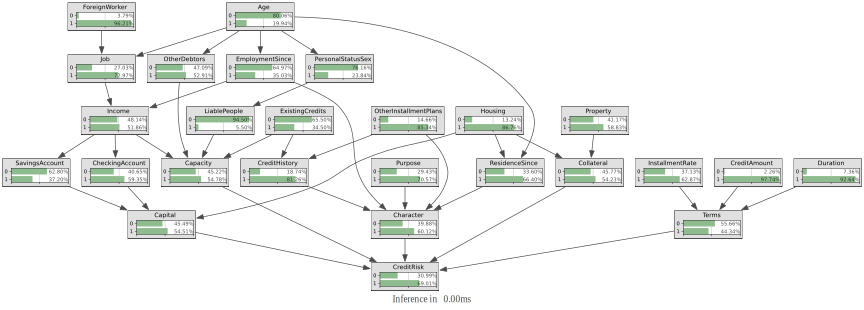

In [31]:
gum.config.reset()
# Inference
gnb.showInference(bn, size="12")

Given 5 C's lets test it's impact on the perceived Credit Risk

{'Income', 'Terms', 'Character', 'Capital', 'Capacity', 'CreditRisk', 'Collateral'}


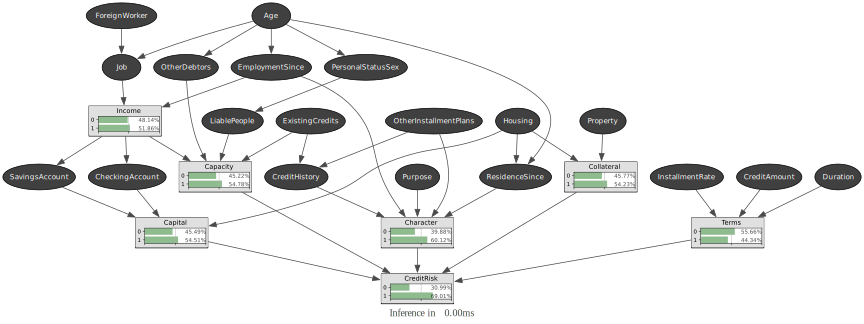

In [32]:
targets = unobserved_vars.union({"CreditRisk"})
print(targets)
gnb.showInference(bn,evs={},targets=targets, size="12")
# gnb.showInference(bn,evs={"CreditRisk": "Good"},targets=targets, size="12")
# gnb.showInference(bn,evs={"CreditRisk": "Bad"},targets=targets, size="12")
# gnb.showInference(bn,evs={"Character": "bad"},targets=targets, size="12")

# Causal reasoning

We explore the effect that parent nodes have on the perceived credit risk of applicants, investigating the link between employment, asset ownership and the financial wellbeing of applicants. 

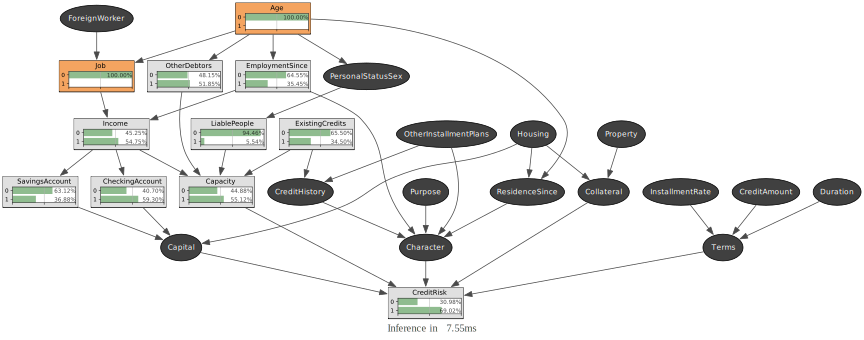

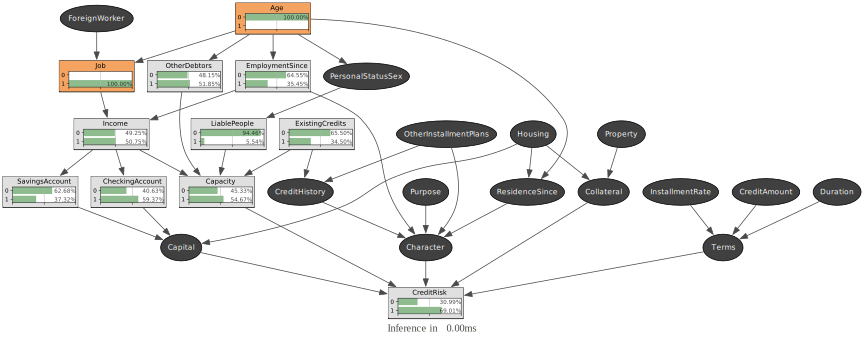

In [33]:
employment = {"CreditRisk", "Job", "Age", "EmploymentSince", "Income", "Capacity",
              "LiablePeople", "ExistingCredits", "OtherDebtors", "CheckingAccount", "SavingsAccount"}

gnb.showInference(bn,evs={"Age": 0, "Job": 0},targets=employment, size="12")
gnb.showInference(bn,evs={"Age": 0, "Job": 1},targets=employment, size="12")
# gnb.showInference(bn,evs={"CreditRisk": "Bad"},targets=employment, size="12")
# gnb.showInference(bn,evs={"Character": "bad"},targets=employment, size="12")

In [34]:
# Save the bn
bn.saveBIF('GermanCreditManual_filled.bif')

# Creating Influence diagram


Ensuring that 5 C's are used in deciding whether to approve or deny loan

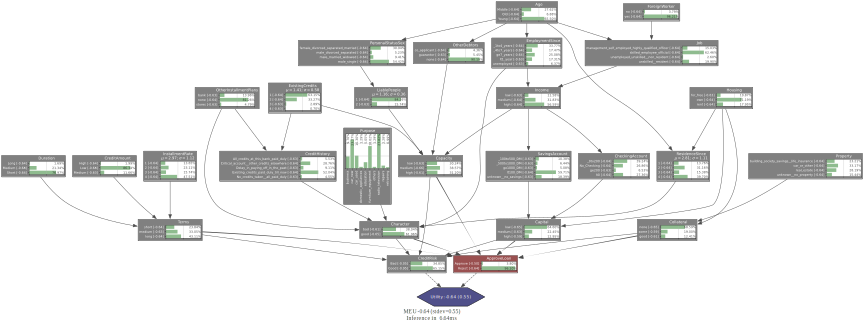

In [35]:
# Load the influence diagram
influence_diagram = gum.loadID('influence_diagram.xml')

# Add the parents of credit risk to the action node

parents = bn.parents("CreditRisk")
decision_name = "ApproveLoan"

for parent in parents:
    parent_name = bn.variable(parent).name()
    influence_diagram.addArc(parent_name, decision_name)

gnb.showInference(influence_diagram, size="12")

# Structure and weights

1) The structure was decided upon based on the 5 C's of Credit framework. All parent nodes are used to influence the perceived Credit Risk of a given applicant. Majority discussed in previous sections.

# Parameters and weights

2) The set of variables contained in the dataset allowed us to build probability tables based on the occurence of values in the data. The dataset grounds some of the beliefs we have about applicants. 

Firstly, the variables not present in the dataset were assigned the following probability distribution:

"Collateral": {'none': 0.7, 'some': 0.2, 'good': 0.1},  
"Capital": {'low': 0.7, 'medium': 0.2, 'high': 0.1},
"Capacity": {'low': 0.3, 'medium': 0.4, 'high': 0.3},
"Terms": {'short': 0.45, 'medium': 0.35, 'long': 0.2},
"Character": {'bad': 0.22, 'good': 0.78},
"Income": {'low': 0.1, 'medium': 0.3, 'high': 0.6}

Collateral: Majority of applicants for this type of loan are not securing it with significant assets. Most (70%) offer no collateral, which is typical for personal or consumer loans. A small fraction have some or good collateral, representing a lower-risk minority. Often, one would need to own a large asset to use it as collateral and the assumption is that few individuals would use their homes as collateral for a large credit amount due to the riskiness of the decision.
However, given that majority of sampled applicants in the dataset had a car or owned a house, the probability that an applicant had some collateral should not be too low.

Capital: The assumption is that fewer applicants were high net worth individuals with available capital to use for the loan. Based on the data most applicants applied for smaller credit amounts and more often than not small loans would not be made by individuals with large capital resources.

Terms: Given the preference for short-term loans. The highest probability (45%) is assigned to "short" terms, which implies that loans are for smaller amounts that can be paid back quickly, or that the lender prefers to minimize long-term risk exposure.

Character: This encodes a strong prior and optimism that most applicants have paid previous credit and discipline.

Income: Suggests the model is focused on a population where "high" income is the most common characteristic (60%). This could mean the loan product targets more affluent customers, or that a "high" income is a soft prerequisite for consideration, thus filtering out most low-income individuals. This ties in with the optimistic assumption of positive borrowers who have good credit history. As a bank one would advertise credit products to high income individuals who have a good credit history.

After adding synthetic data for these variables in the data frame according to these prior marginals, we populate the tables using the joint distributions derived from the co-occurence of values that the random variables take on in the dataset.

# Inference using the influence diagram


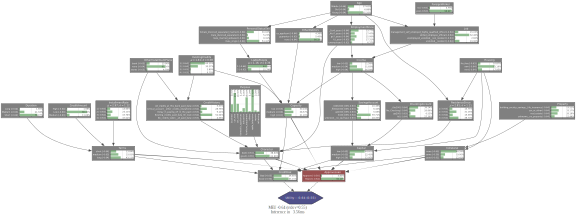

In [36]:
# Diagnostic Inference
gnb.showInference(influence_diagram)


## Evaluate the Influence Diagram on processed_credit data

We evaluate decision quality by:
- Mapping row values to the influence diagram's chance node labels (we reuse the label-aligned `vars_df`).
- For each sampled row, randomly selecting a subset of observed variables (excluding the target `CreditRisk`) as evidence.
- Running influence diagram inference to compute expected utility for each decision and selecting the optimal decision (MEU).
- Reporting summary stats: average MEU, realized utility against true `CreditRisk`, decision frequencies, and average evidence size.

In [37]:
# ID evaluation on processed_credit via per-row sampled evidence
import random
from collections import Counter

# Ensure the influence diagram is present
assert 'influence_diagram' in globals(), "Run the cell that loads 'influence_diagram' first."

# Identify nodes
decision_name = 'ApproveLoan'
utility_name = 'Utility'
risk_name = 'CreditRisk'

# Set up inference engine
ie = gum.ShaferShenoyLIMIDInference(influence_diagram)
try:
    ie.addNoForgettingAssumption([decision_name])  # provide decision order (single decision)
except TypeError:
    # Some versions require ids instead of names
    ie.addNoForgettingAssumption([influence_diagram.idFromName(decision_name)])

# Chance vars list
chance_vars = [
    n for n in influence_diagram.names()
    if not influence_diagram.isDecisionNode(influence_diagram.idFromName(n))
    and not influence_diagram.isUtilityNode(influence_diagram.idFromName(n))
]

# Build label mappings from ID variables (string labels)
label_lists = {}
label_sets = {}
label_lower_to_canonical = {}
for name in chance_vars:
    var = influence_diagram.variableFromName(name)
    try:
        labels = list(var.labels())
    except Exception:
        labels = [str(var.label(i)) for i in range(var.domainSize())]
    labels = [str(l) for l in labels]
    label_lists[name] = labels
    label_sets[name] = set(labels)
    label_lower_to_canonical[name] = {l.lower(): l for l in labels}

# Align and coerce dataframe values to ID labels
original_df = vars_df.copy()
df_labels = set(chance_vars).intersection(set(original_df.columns))
df_labels = sorted(df_labels)
raw_df = original_df[df_labels].copy()

# Coercion function to map raw values to ID label strings
def coerce_value(var_name: str, val):
    labels = label_lists[var_name]
    label_set = label_sets[var_name]
    lower_map = label_lower_to_canonical[var_name]

    if pd.isna(val):
        return None
    s = str(val).strip()

    # 1) exact match
    if s in label_set:
        return s

    # 2) case-insensitive match to canonical
    low = s.lower()
    if low in lower_map:
        return lower_map[low]

    # 3) integer index to label (for RangeVariable-like)
    try:
        iv = int(float(s))
        if 0 <= iv < len(labels):
            return str(labels[iv])
    except Exception:
        pass

    # 4) deterministic 1-1 mapping by sorted uniques vs labels if sizes align
    # Note: we construct this mapping per column once (below) to ensure consistency
    return None

# Build per-column fallback mappings (sorted unique values -> labels) when needed
fallback_maps = {}
for col in raw_df.columns:
    uniques = sorted({str(v).strip() for v in raw_df[col].dropna().unique()})
    labels = label_lists[col]
    if len(uniques) == len(labels):
        fallback_maps[col] = dict(zip(uniques, labels))

# Apply coercion
coerced_df = pd.DataFrame(index=raw_df.index)
for col in raw_df.columns:
    out_col = []
    for v in raw_df[col].values:
        mapped = coerce_value(col, v)
        if mapped is None and not pd.isna(v):
            sv = str(v).strip()
            if col in fallback_maps and sv in fallback_maps[col]:
                mapped = fallback_maps[col][sv]
        out_col.append(mapped if mapped is not None else None)
    coerced_df[col] = out_col

# Verify that coerced values are all in ID labels
problem_vars = []
for col in coerced_df.columns:
    vals = {str(v) for v in coerced_df[col].dropna().unique()}
    if not vals.issubset(label_sets[col]):
        problem_vars.append(col)
if problem_vars:
    print('Warning: still unmapped columns after coercion:', problem_vars)

# For realized utility, coerce ground-truth risk label too (if present)
original_df_coerced = original_df.copy()
if risk_name in original_df_coerced.columns:
    risk_labels = label_lists[risk_name]
    risk_set = label_sets[risk_name]
    risk_lower = label_lower_to_canonical[risk_name]
    mapped = []
    for v in original_df_coerced[risk_name].values:
        if pd.isna(v):
            mapped.append(None)
            continue
        s = str(v).strip()
        if s in risk_set:
            mapped.append(s)
            continue
        if s.lower() in risk_lower:
            mapped.append(risk_lower[s.lower()])
            continue
        try:
            iv = int(float(s))
            if 0 <= iv < len(risk_labels):
                mapped.append(str(risk_labels[iv]))
                continue
        except Exception:
            pass
        # fallback by size
        if risk_name in fallback_maps and s in fallback_maps[risk_name]:
            mapped.append(fallback_maps[risk_name][s])
        else:
            mapped.append(None)
    original_df_coerced[risk_name] = mapped

# Row sampling and evidence construction
n_rows = len(coerced_df)
sample_size = min(1000, n_rows)  # configurable
rng = np.random.default_rng(2024)
row_indices = rng.choice(n_rows, size=sample_size, replace=False)

# For each row, randomly select k evidence variables (exclude explicit target 'CreditRisk')
exclude_vars = {risk_name}  # do not use target as evidence
eligible_vars = [c for c in coerced_df.columns if c not in exclude_vars]
min_evidence = 5
max_evidence = len(eligible_vars)

results = []

# Pre-fetch structures for EU computation
ut_tensor = influence_diagram.utility(utility_name)
risk_var = influence_diagram.variableFromName(risk_name)
risk_labels = [str(l) for l in risk_var.labels()]

def expected_utility_for_decision(ie, decision_label: str) -> float:
    # Fix decision as evidence, infer posterior over CreditRisk, then compute EU = E[U | ev, decision]
    ie.updateEvidence({decision_name: decision_label})
    ie.makeInference()
    post = ie.posterior(risk_name)
    try:
        probs = list(map(float, post.tolist()))
    except Exception:
        probs = [float(post[i]) for i in range(len(risk_labels))]
    eu = 0.0
    for p, rl in zip(probs, risk_labels):
        try:
            u = float(ut_tensor[rl, decision_label])
        except Exception:
            u = float(ut_tensor[risk_labels.index(rl), [decision_label].index(decision_label)])
        eu += p * u
    return eu

for i in row_indices:
    row = coerced_df.iloc[i]
    # random evidence subset size
    if max_evidence < 1:
        ev_vars = []
    else:
        k = int(rng.integers(min_evidence, max_evidence + 1)) if max_evidence >= min_evidence else int(max_evidence)
        ev_vars = list(rng.choice(eligible_vars, size=k, replace=False)) if k > 0 else []
    evidence = {v: row[v] for v in ev_vars if row[v] is not None and row[v] in label_sets[v]}

    # Build inference with those evidences
    ie.eraseAllEvidence()
    if evidence:
        ie.setEvidence(evidence)

    # Compute EU for both actions and MEU
    dvar = influence_diagram.variableFromName(decision_name)
    dlabels = [str(l) for l in dvar.labels()]
    utilities = {dlab: expected_utility_for_decision(ie, dlab) for dlab in dlabels}
    optimal = max(utilities.items(), key=lambda kv: kv[1])[0]
    exp_utility = utilities[optimal]

    # Realized utility under the true risk for the chosen action (if available)
    realized_u = None
    if risk_name in original_df_coerced.columns:
        true_risk = original_df_coerced.iloc[i][risk_name]
        if true_risk is not None and true_risk in label_sets[risk_name]:
            try:
                realized_u = float(ut_tensor[true_risk, optimal])
            except Exception:
                realized_u = None

    results.append({
        'row': int(i),
        'evidence_size': int(len(evidence)),
        'evidence': evidence,
        'EU_Approve': utilities.get('Approve', np.nan),
        'EU_Reject': utilities.get('Reject', np.nan),
        'MEU': float(exp_utility),
        'decision': optimal,
        'true_CreditRisk': true_risk if risk_name in original_df_coerced.columns else None,
        'realized_utility': realized_u
    })

perf_df = pd.DataFrame(results)
decision_counts = perf_df['decision'].value_counts()
avg_meu = perf_df['MEU'].mean()
avg_evidence = perf_df['evidence_size'].mean()
avg_actual_utility = perf_df['realized_utility'].dropna().mean() if perf_df['realized_utility'].notna().any() else None
approve_rate = decision_counts.get('Approve', 0) / len(perf_df)

summary = {
    'n_rows_evaluated': len(perf_df),
    'avg_MEU': avg_meu,
    'avg_evidence_size': avg_evidence,
    'approve_rate': approve_rate,
    'avg_realized_utility': avg_actual_utility
}

summary, perf_df.head(10)

C:\Users\Rowan Rosenberg\AppData\Local\Temp\ipykernel_356\1448757771.py:173: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  u = float(ut_tensor[rl, decision_label])
C:\Users\Rowan Rosenberg\AppData\Local\Temp\ipykernel_356\1448757771.py:207: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  realized_u = float(ut_tensor[true_risk, optimal])


({'n_rows_evaluated': 1000,
  'avg_MEU': np.float64(-0.6474882466119775),
  'avg_evidence_size': np.float64(14.913),
  'approve_rate': 0.0,
  'avg_realized_utility': np.float64(-0.7)},
    row  evidence_size                                           evidence  \
 0  110             14  {'Property': 'car_or_other', 'InstallmentRate'...   
 1  194             25  {'Capital': 'low', 'Property': 'building_socie...   
 2  854             19  {'LiablePeople': '1', 'ResidenceSince': '1', '...   
 3  121             20  {'OtherDebtors': 'none', 'Purpose': 'car_used'...   
 4  241             17  {'Capital': 'low', 'CreditAmount': 'Low', 'For...   
 5  406             15  {'OtherInstallmentPlans': 'none', 'CheckingAcc...   
 6  731             14  {'Property': 'real_estate', 'SavingsAccount': ...   
 7  502             17  {'Property': 'real_estate', 'CreditAmount': 'L...   
 8  568             18  {'CheckingAccount': '_0to200', 'Capital': 'med...   
 9  325             23  {'OtherInstallmentPla

### Threshold policy (0.5) using predicted CreditRisk

This policy selects Approve if P(CreditRisk = Good | evidence) ≥ 0.5, otherwise Reject. We compute the posterior over CreditRisk from the Bayesian Network (to avoid conditioning on a fixed decision) using the same row sampling and evidence selection.

C:\Users\Rowan Rosenberg\AppData\Local\Temp\ipykernel_356\4061340382.py:74: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  u = float(ut_tensor[rl, decision])
C:\Users\Rowan Rosenberg\AppData\Local\Temp\ipykernel_356\4061340382.py:86: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  realized_u = float(ut_tensor[true_risk, decision])



Comparison of different thresholds:


,threshold,n_rows_evaluated,approve_rate,avg_evidence_size,avg_p_good,avg_policy_EU,avg_realized_utility
threshold,,,,,,,
0.3,0.3,1000.0,1.000,14.983,0.648351,-1.758244,-1.500
0.4,0.4,1000.0,1.000,15.057,0.648389,-1.758056,-1.500
0.5,0.5,1000.0,0.989,15.030,0.647363,-1.740931,-1.493
0.6,0.6,1000.0,0.838,14.811,0.648893,-1.483184,-1.404
0.7,0.7,1000.0,0.115,14.782,0.649788,-0.717089,-0.831
0.8,0.8,1000.0,0.004,15.241,0.647656,-0.648127,-0.708
0.9,0.9,1000.0,0.000,15.380,0.647087,-0.647087,-0.700


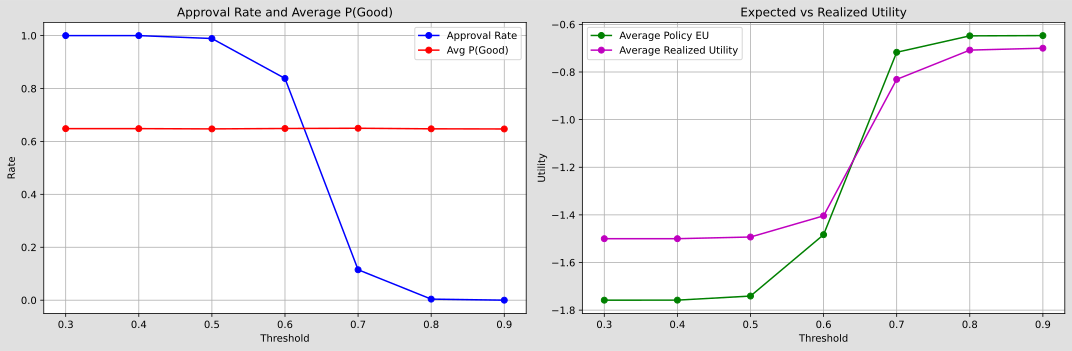

In [38]:
# Evaluate different threshold policies based on P(CreditRisk=Good | evidence)
assert 'influence_diagram' in globals(), "Run earlier cells to load the influence diagram first."
assert 'coerced_df' in globals(), "Run the ID evaluation cell first to build 'coerced_df' and mappings."
risk_name = 'CreditRisk'
decision_name = 'ApproveLoan'
utility_name = 'Utility'

# Set up inference engine for influence diagram
ie = gum.ShaferShenoyLIMIDInference(influence_diagram)
try:
    ie.addNoForgettingAssumption([decision_name])
except TypeError:
    ie.addNoForgettingAssumption([influence_diagram.idFromName(decision_name)])

# Chance vars we can use as evidence (exclude target)
eligible_vars = [c for c in coerced_df.columns if c != risk_name]

# Reuse same sampling indices if available; otherwise recreate
if 'row_indices' not in globals():
    n_rows = len(coerced_df)
    rng = np.random.default_rng(2024)
    row_indices = rng.choice(n_rows, size=min(300, n_rows), replace=False)
else:
    rng = np.random.default_rng(2024)

min_evidence = 5
max_evidence = len(eligible_vars)

# Utility tensor and label maps from ID
ut_tensor = influence_diagram.utility(utility_name)
risk_var = influence_diagram.variableFromName(risk_name)
risk_labels = [str(l) for l in risk_var.labels()]

# Different threshold values to evaluate
thresholds = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
all_results = {}

for threshold in thresholds:
    results_thresh = []
    
    for i in row_indices:
        row = coerced_df.iloc[i]
        # Sample evidence subset
        if max_evidence < 1:
            ev_vars = []
        else:
            k = int(rng.integers(min_evidence, max_evidence + 1)) if max_evidence >= min_evidence else int(max_evidence)
            ev_vars = list(rng.choice(eligible_vars, size=k, replace=False)) if k > 0 else []
        
        # Collect evidence using original values from influence diagram
        ev = {v: row[v] for v in ev_vars if row[v] is not None}

        # Get posterior over CreditRisk using influence diagram
        ie.eraseAllEvidence()
        if ev:
            ie.setEvidence(ev)
        ie.makeInference()
        post = ie.posterior(risk_name)
        try:
            probs = list(map(float, post.tolist()))
        except Exception:
            probs = [float(post[i]) for i in range(len(risk_labels))]

        # Find P(Good) using influence diagram labels
        good_idx = risk_labels.index('Good')
        p_good = probs[good_idx]

        decision = 'Approve' if p_good >= threshold else 'Reject'

        # Compute EU under selected decision using ID utilities
        eu = 0.0
        for p, rl in zip(probs, risk_labels):
            try:
                u = float(ut_tensor[rl, decision])
            except Exception:
                u = 0.0
            eu += p * u

        # Realized utility using true risk label if available
        realized_u = None
        true_risk = None
        if risk_name in original_df_coerced.columns:
            true_risk = original_df_coerced.iloc[i][risk_name]
            if true_risk is not None:
                try:
                    realized_u = float(ut_tensor[true_risk, decision])
                except Exception:
                    realized_u = None

        results_thresh.append({
            'row': int(i),
            'evidence_size': int(len(ev)),
            'evidence': ev,
            'p_good': float(p_good),
            'decision': decision,
            'EU_policy': float(eu),
            'true_CreditRisk': true_risk,
            'realized_utility': realized_u
        })

    perf_thresh = pd.DataFrame(results_thresh)
    summary = {
        'threshold': threshold,
        'n_rows_evaluated': len(perf_thresh),
        'approve_rate': (perf_thresh['decision'] == 'Approve').mean(),
        'avg_evidence_size': perf_thresh['evidence_size'].mean(),
        'avg_p_good': perf_thresh['p_good'].mean(),
        'avg_policy_EU': perf_thresh['EU_policy'].mean(),
        'avg_realized_utility': perf_thresh['realized_utility'].dropna().mean() if perf_thresh['realized_utility'].notna().any() else None
    }
    all_results[threshold] = summary

# Create comparison DataFrame
comparison_df = pd.DataFrame(all_results).T
comparison_df.index.name = 'threshold'
comparison_df = comparison_df.sort_index()

# Display summary comparison and detailed stats for threshold = 0.5
print("\nComparison of different thresholds:")
display(comparison_df)

# Plot key metrics
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(comparison_df.index, comparison_df['approve_rate'], 'b-o', label='Approval Rate')
ax1.plot(comparison_df.index, comparison_df['avg_p_good'], 'r-o', label='Avg P(Good)')
ax1.set_xlabel('Threshold')
ax1.set_ylabel('Rate')
ax1.set_title('Approval Rate and Average P(Good)')
ax1.legend()
ax1.grid(True)

ax2.plot(comparison_df.index, comparison_df['avg_policy_EU'], 'g-o', label='Average Policy EU')
ax2.plot(comparison_df.index, comparison_df['avg_realized_utility'], 'm-o', label='Average Realized Utility')
ax2.set_xlabel('Threshold')
ax2.set_ylabel('Utility')
ax2.set_title('Expected vs Realized Utility')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

# Inference Reliability Testing

We'll test how reliable our Bayesian Network's inferences are by comparing predicted vs actual values for each variable. For each variable:
1. We'll randomly sample rows from our dataset
2. For each row, we'll randomly select a subset of other variables as evidence
3. Use the BN to predict the target variable's value
4. Compare the prediction against the true value
5. Calculate accuracy metrics

This helps us understand which variables our model can predict reliably and where it might need improvement.


Testing inference reliability for Terms
Accuracy: 0.093, Avg Confidence: 0.439, N=1000
Accuracy: 0.093, Avg Confidence: 0.439, N=1000


predicted_value,long,medium,short,All
true_value,,,,
medium,379,86,9,474
short,417,102,7,526
All,796,188,16,1000



Testing inference reliability for ExistingCredits
Accuracy: 0.716, Avg Confidence: 0.723, N=1000
Accuracy: 0.716, Avg Confidence: 0.723, N=1000


predicted_value,1,2,All
true_value,,,
1,716,250,966
3,15,13,28
4,4,2,6
All,735,265,1000



Testing inference reliability for Collateral
Accuracy: 0.476, Avg Confidence: 0.692, N=1000
Accuracy: 0.476, Avg Confidence: 0.692, N=1000


predicted_value,none,All
true_value,,
none,476,476
some,524,524
All,1000,1000



Testing inference reliability for Housing
Accuracy: 0.707, Avg Confidence: 0.717, N=1000
Accuracy: 0.707, Avg Confidence: 0.717, N=1000


predicted_value,for_free,own,rent,All
true_value,,,,
for_free,0,106,2,108
own,1,705,7,713
rent,4,173,2,179
All,5,984,11,1000



Testing inference reliability for Capacity
Accuracy: 0.461, Avg Confidence: 0.401, N=1000
Accuracy: 0.461, Avg Confidence: 0.401, N=1000


predicted_value,high,low,medium,All
true_value,,,,
low,38,124,347,509
medium,52,102,337,491
All,90,226,684,1000



Testing inference reliability for ForeignWorker
Accuracy: 0.963, Avg Confidence: 0.962, N=1000
Accuracy: 0.963, Avg Confidence: 0.962, N=1000


predicted_value,yes,All
true_value,,
no,37,37
yes,963,963
All,1000,1000



Testing inference reliability for OtherInstallmentPlans
Accuracy: 0.819, Avg Confidence: 0.820, N=1000
Accuracy: 0.819, Avg Confidence: 0.820, N=1000


predicted_value,bank,none,All
true_value,,,
bank,16,123,139
none,11,803,814
stores,6,41,47
All,33,967,1000



Testing inference reliability for PersonalStatusSex
Accuracy: 0.548, Avg Confidence: 0.509, N=1000
Accuracy: 0.548, Avg Confidence: 0.509, N=1000


predicted_value,male_single,All
true_value,,
female_divorced_separated_married,310,310
male_divorced_separated,50,50
male_married_widowed,92,92
male_single,548,548
All,1000,1000



Testing inference reliability for Income
Accuracy: 0.015, Avg Confidence: 0.562, N=1000
Accuracy: 0.015, Avg Confidence: 0.562, N=1000


predicted_value,high,low,medium,All
true_value,,,,
low,479,2,9,490
medium,496,1,13,510
All,975,3,22,1000



Testing inference reliability for Purpose
Accuracy: 0.274, Avg Confidence: 0.288, N=1000
Accuracy: 0.274, Avg Confidence: 0.288, N=1000


predicted_value,business,car_new,furniture_equipment,radio_television,All
true_value,,,,,
business,0,7,2,88,97
car_new,2,18,2,212,234
car_used,1,5,0,97,103
domestic_appliances,0,0,0,12,12
education,0,2,1,47,50
furniture_equipment,1,10,2,168,181
others,0,2,0,10,12
radio_television,0,23,3,254,280
repairs,0,0,0,22,22



Testing inference reliability for CreditHistory
Accuracy: 0.535, Avg Confidence: 0.659, N=1000
Accuracy: 0.535, Avg Confidence: 0.659, N=1000


predicted_value,All_credits_at_this_bank_paid_duly,Critical_account__other_credits_elsewhere,Existing_credits_paid_duly_till_now,All
true_value,,,,
All_credits_at_this_bank_paid_duly,0,0,49,49
Critical_account__other_credits_elsewhere,0,11,282,293
Delay_in_paying_off_in_the_past,0,0,88,88
Existing_credits_paid_duly_till_now,1,5,524,530
No_credits_taken__all_paid_duly,0,1,39,40
All,1,17,982,1000



Testing inference reliability for SavingsAccount
Accuracy: 0.603, Avg Confidence: 0.595, N=1000
Accuracy: 0.603, Avg Confidence: 0.595, N=1000


predicted_value,lt100_DM,All
true_value,,
_100to500_DM,103,103
_500to1000_DM,63,63
ge1000_DM,48,48
lt100_DM,603,603
unknown__no_savings,183,183
All,1000,1000



Testing inference reliability for Job
Accuracy: 0.630, Avg Confidence: 0.616, N=1000
Accuracy: 0.630, Avg Confidence: 0.616, N=1000


predicted_value,skilled_employee_official,unemployed_unskilled__non_resident,unskilled__resident,All
true_value,,,,
management_self_employed_highly_qualified_officer,146,0,2,148
skilled_employee_official,627,0,3,630
unemployed_unskilled__non_resident,20,1,1,22
unskilled__resident,198,0,2,200
All,991,1,8,1000



Testing inference reliability for CheckingAccount
Accuracy: 0.269, Avg Confidence: 0.397, N=1000
Accuracy: 0.269, Avg Confidence: 0.397, N=1000


predicted_value,No_Checking,_0to200,lt0,All
true_value,,,,
No_Checking,4,390,0,394
_0to200,3,265,1,269
ge200,0,62,1,63
lt0,0,274,0,274
All,7,991,2,1000



Testing inference reliability for CreditAmount
Accuracy: 0.865, Avg Confidence: 0.848, N=1000
Accuracy: 0.865, Avg Confidence: 0.848, N=1000


predicted_value,Low,All
true_value,,
High,19,19
Low,865,865
Medium,116,116
All,1000,1000



Testing inference reliability for Capital
Accuracy: 0.497, Avg Confidence: 0.656, N=1000
Accuracy: 0.497, Avg Confidence: 0.656, N=1000


predicted_value,high,low,medium,All
true_value,,,,
low,1,495,5,501
medium,1,496,2,499
All,2,991,7,1000



Testing inference reliability for EmploymentSince
Accuracy: 0.373, Avg Confidence: 0.384, N=1000
Accuracy: 0.373, Avg Confidence: 0.384, N=1000


predicted_value,_1to4_years,_4to7_years,ge7_years,lt1_year,unemployed,All
true_value,,,,,,
_1to4_years,262,2,73,2,0,339
_4to7_years,135,2,35,2,0,174
ge7_years,136,3,108,3,3,253
lt1_year,147,2,22,1,0,172
unemployed,34,1,25,2,0,62
All,714,10,263,10,3,1000



Testing inference reliability for OtherDebtors
Accuracy: 0.907, Avg Confidence: 0.905, N=1000
Accuracy: 0.907, Avg Confidence: 0.905, N=1000


predicted_value,none,All
true_value,,
co_applicant,41,41
guarantor,52,52
none,907,907
All,1000,1000



Testing inference reliability for Age
Accuracy: 0.683, Avg Confidence: 0.689, N=1000
Accuracy: 0.683, Avg Confidence: 0.689, N=1000


predicted_value,Middle,Old,Young,All
true_value,,,,
Middle,79,1,196,276
Old,21,5,42,68
Young,56,1,599,656
All,156,7,837,1000



Testing inference reliability for Duration
Accuracy: 0.771, Avg Confidence: 0.766, N=1000
Accuracy: 0.771, Avg Confidence: 0.766, N=1000


predicted_value,Short,All
true_value,,
Long,16,16
Medium,213,213
Short,771,771
All,1000,1000



Testing inference reliability for Property
Accuracy: 0.327, Avg Confidence: 0.339, N=1000
Accuracy: 0.327, Avg Confidence: 0.339, N=1000


predicted_value,building_society_savings__life_insurance,car_or_other,All
true_value,,,
building_society_savings__life_insurance,10,222,232
car_or_other,15,317,332
real_estate,15,267,282
unknown__no_property,4,150,154
All,44,956,1000



Testing inference reliability for InstallmentRate
Accuracy: 0.476, Avg Confidence: 0.473, N=1000
Accuracy: 0.476, Avg Confidence: 0.473, N=1000


predicted_value,4,All
true_value,,
1,367,367
3,157,157
4,476,476
All,1000,1000



Testing inference reliability for CreditRisk
Accuracy: 0.678, Avg Confidence: 0.647, N=1000
Accuracy: 0.678, Avg Confidence: 0.647, N=1000


predicted_value,Bad,Good,All
true_value,,,
Bad,20,280,300
Good,42,658,700
All,62,938,1000



Testing inference reliability for LiablePeople
Accuracy: 1.000, Avg Confidence: 0.846, N=1000
Accuracy: 1.000, Avg Confidence: 0.846, N=1000


predicted_value,1,All
true_value,,
1,1000,1000
All,1000,1000



Testing inference reliability for ResidenceSince
Accuracy: 0.306, Avg Confidence: 0.464, N=1000
Accuracy: 0.306, Avg Confidence: 0.464, N=1000


predicted_value,1,2,4,All
true_value,,,,
1,2,248,188,438
3,0,72,77,149
4,0,109,304,413
All,2,429,569,1000



Testing inference reliability for Character
Accuracy: 0.736, Avg Confidence: 0.649, N=1000
Accuracy: 0.736, Avg Confidence: 0.649, N=1000


predicted_value,bad,good,All
true_value,,,
bad,14,197,211
good,67,722,789
All,81,919,1000


,variable,accuracy,avg_confidence,n_predictions
23,LiablePeople,1.000,0.846067,1000
5,ForeignWorker,0.963,0.961536,1000
17,OtherDebtors,0.907,0.904713,1000
14,CreditAmount,0.865,0.848404,1000
6,OtherInstallmentPlans,0.819,0.820497,1000
19,Duration,0.771,0.766089,1000
25,Character,0.736,0.648760,1000
1,ExistingCredits,0.716,0.723165,1000
3,Housing,0.707,0.717172,1000
18,Age,0.683,0.688748,1000


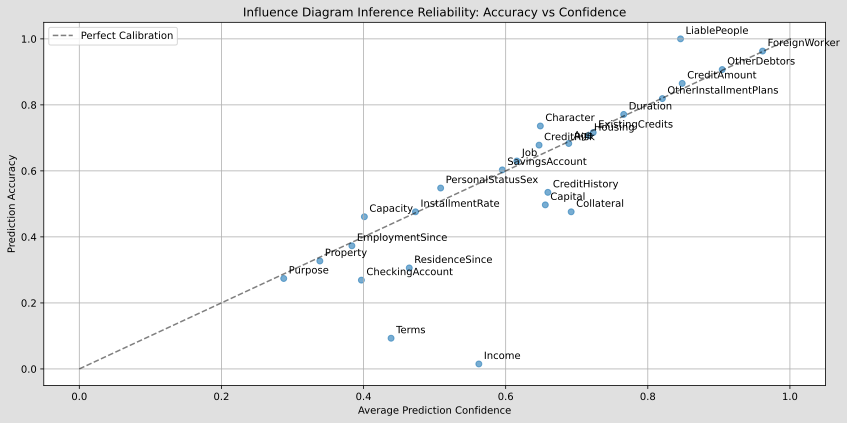

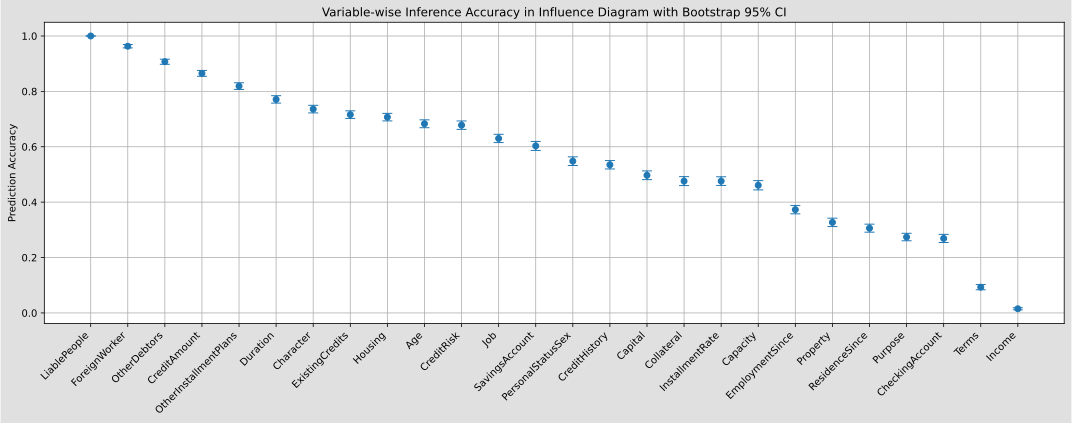

In [40]:
# Test inference reliability for all variables
def test_inference_reliability(id_model, df, n_samples=1000, min_evidence=5):
    """
    Test inference reliability by comparing predicted vs true values for each variable
    using the Influence Diagram.
    
    Args:
        id_model: PyAgrum Influence Diagram
        df: DataFrame with aligned variable values
        n_samples: Number of rows to sample for testing
        min_evidence: Minimum number of evidence variables to use
    
    Returns:
        Dictionary with accuracy metrics for each variable
    """
    rng = np.random.default_rng(2024)
    results = {}
    
    # Sample rows
    row_indices = rng.choice(len(df), size=min(n_samples, len(df)), replace=False)
    
    # Get all chance nodes (excluding decision and utility nodes)
    chance_nodes = [
        n for n in id_model.names()
        if not id_model.isDecisionNode(id_model.idFromName(n))
        and not id_model.isUtilityNode(id_model.idFromName(n))
    ]
    
    # For each variable in the network
    for target_var in chance_nodes:
        print(f"\nTesting inference reliability for {target_var}")
        
        # Variables we can use as evidence (exclude target and decision nodes)
        eligible_vars = [v for v in chance_nodes if v != target_var]
        max_evidence = len(eligible_vars)
        
        var_results = []
        ie = gum.ShaferShenoyLIMIDInference(id_model)
        try:
            ie.addNoForgettingAssumption(['ApproveLoan'])
        except TypeError:
            ie.addNoForgettingAssumption([id_model.idFromName('ApproveLoan')])
        
        # Test each sampled row
        for i in row_indices:
            row = df.iloc[i]
            
            # Sample evidence variables
            k = int(rng.integers(min_evidence, max_evidence + 1))
            ev_vars = list(rng.choice(eligible_vars, size=k, replace=False))
            evidence = {v: row[v] for v in ev_vars if row[v] is not None and str(row[v]) in [str(l) for l in id_model.variableFromName(v).labels()]}
            
            # True value
            true_value = row[target_var]
            if pd.isna(true_value):
                continue
                
            # Make inference
            try:
                ie.eraseAllEvidence()
                ie.setEvidence(evidence)
                ie.makeInference()
                post = ie.posterior(target_var)
                
                # Get predicted value (MAP estimate)
                try:
                    probs = list(map(float, post.tolist()))
                except:
                    probs = [float(post[i]) for i in range(post.size())]
                    
                pred_value = id_model.variableFromName(target_var).labels()[np.argmax(probs)]
                max_prob = max(probs)
                
                var_results.append({
                    'row': i,
                    'evidence_size': len(evidence),
                    'true_value': true_value,
                    'predicted_value': pred_value,
                    'prediction_confidence': max_prob
                })
            except Exception as e:
                print(f"Error on row {i}: {str(e)}")
                
        # Calculate metrics
        if var_results:
            df_results = pd.DataFrame(var_results)
            accuracy = (df_results['true_value'] == df_results['predicted_value']).mean()
            avg_confidence = df_results['prediction_confidence'].mean()
            
            # Confusion matrix
            true_vals = pd.Series(df_results['true_value'])
            pred_vals = pd.Series(df_results['predicted_value'])
            conf_matrix = pd.crosstab(true_vals, pred_vals, margins=True)
            
            results[target_var] = {
                'accuracy': accuracy,
                'avg_confidence': avg_confidence,
                'n_predictions': len(df_results),
                'confusion_matrix': conf_matrix,
                'detailed_results': df_results
            }
            
            print(f"Accuracy: {accuracy:.3f}, Avg Confidence: {avg_confidence:.3f}, N={len(df_results)}")
            display(conf_matrix)
            
    return results

# Run the reliability test using the influence diagram
reliability_results = test_inference_reliability(influence_diagram, coerced_df)

# Create summary DataFrame
summary_metrics = pd.DataFrame([
    {
        'variable': var,
        'accuracy': res['accuracy'],
        'avg_confidence': res['avg_confidence'],
        'n_predictions': res['n_predictions']
    }
    for var, res in reliability_results.items()
])

summary_metrics = summary_metrics.sort_values('accuracy', ascending=False)
display(summary_metrics)

# Plot accuracy vs confidence
plt.figure(figsize=(12, 6))
plt.scatter(summary_metrics['avg_confidence'], summary_metrics['accuracy'], 
           alpha=0.6)

# Add variable labels
for _, row in summary_metrics.iterrows():
    plt.annotate(row['variable'], 
                (row['avg_confidence'], row['accuracy']),
                xytext=(5, 5), textcoords='offset points')

plt.xlabel('Average Prediction Confidence')
plt.ylabel('Prediction Accuracy')
plt.title('Influence Diagram Inference Reliability: Accuracy vs Confidence')
plt.grid(True)

# Add diagonal line for reference
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5, 
         label='Perfect Calibration')
plt.legend()

plt.tight_layout()
plt.show()

# Plot variable-wise accuracy with error bars
plt.figure(figsize=(15, 6))
accuracy_std = []

for var in summary_metrics['variable']:
    results = reliability_results[var]['detailed_results']
    correct = (results['true_value'] == results['predicted_value']).astype(int)
    # Bootstrap to get confidence intervals
    n_bootstrap = 1000
    bootstrap_accuracies = []
    for _ in range(n_bootstrap):
        sample = correct.sample(n=len(correct), replace=True)
        bootstrap_accuracies.append(sample.mean())
    accuracy_std.append(np.std(bootstrap_accuracies))

plt.errorbar(range(len(summary_metrics)), summary_metrics['accuracy'],
            yerr=accuracy_std, fmt='o', capsize=5)

plt.xticks(range(len(summary_metrics)), 
          summary_metrics['variable'], rotation=45, ha='right')
plt.ylabel('Prediction Accuracy')
plt.title('Variable-wise Inference Accuracy in Influence Diagram with Bootstrap 95% CI')
plt.grid(True)
plt.tight_layout()
plt.show()